In [7]:
class Player:
    def __init__(self, name, position, three_pt, midrange, inside, defense, stamina, speed, iq, usage, rebounding):
        self.name = name
        self.position = position
        self.three_pt = three_pt
        self.midrange = midrange
        self.inside = inside
        self.defense = defense
        self.stamina = stamina
        self.speed = speed
        self.iq = iq
        self.usage = usage
        self.confidence = 1.0
        self.rebounding = rebounding
        
        self.points = 0
        self.shots_made = 0
        self.shots_attempted = 0
        self.assists = 0
        self.offRebounds = 0
        self.defRebounds = 0
        self.totalRebounds = 0

    def adjust_attributes(self, matchup_effect):
        self.three_pt += matchup_effect['three_pt']
        self.midrange += matchup_effect['midrange']
        self.inside += matchup_effect['inside']
        self.defense += matchup_effect['defense']

class Team:
    def __init__(self, name, players):
        self.name = name
        self.players = players
        self.strategy = 'balanced'

    def adjust_strategy(self, new_strategy):
        self.strategy = new_strategy


In [6]:
def calculate_matchup_effect(offensive_player, defensive_player):
    three_pt_effect = offensive_player.three_pt - defensive_player.defense
    midrange_effect = offensive_player.midrange - defensive_player.defense
    inside_effect = offensive_player.inside - defensive_player.defense
    defense_effect = defensive_player.defense - (offensive_player.three_pt + offensive_player.midrange + offensive_player.inside) / 3
    return {'three_pt': three_pt_effect, 'midrange': midrange_effect, 'inside': inside_effect, 'defense': defense_effect}

def apply_matchup_effects(offensive_team, defensive_team):
    for player in offensive_team.players:
        for opponent in defensive_team.players:
            if player.position == opponent.position:
                effect = calculate_matchup_effect(player, opponent)
                player.adjust_attributes(effect)


In [8]:
# Cell 3
import random

def generate_outcomes(players):
    outcomes = []
    for player in players:
        outcomes.extend([
            (f'{player.name} 3pt', player),
            (f'{player.name} Midrange', player),
            (f'{player.name} Inside', player)
        ])
    return outcomes

def get_success_rate(player, outcome):
    if '3pt' in outcome:
        return player.three_pt
    elif 'Midrange' in outcome:
        return player.midrange
    elif 'Inside' in outcome:
        return player.inside
    return 0

def get_rebounding_synergy(team):
    totalRebounding = 0
    for player in team.players:
        totalRebounding += player.rebounding
    return totalRebounding

def choose_rebounder(team):
    weights = [player.rebounding for player in team.players]
    chosen_player = random.choices(team.players, weights=weights, k=1)[0]
    return chosen_player

def simulate_rebound(offensiveTeam, defensiveTeam, play_by_play):
    offRebounding = get_rebounding_synergy(offensiveTeam)
    defRebounding = get_rebounding_synergy(defensiveTeam)
    offReboundingProbability = (offRebounding*0.25)/ (offRebounding+defRebounding)
    if random.random() < offReboundingProbability:
        rebounder = choose_rebounder(offensiveTeam)
        rebounder.offRebounds += 1
        rebounder.totalRebounds += 1
        play_by_play.append(f"{rebounder.name} grabs the offensive rebound.")
        return offensiveTeam, defensiveTeam
        
    else:
        rebounder = choose_rebounder(defensiveTeam)
        rebounder.defRebounds += 1
        rebounder.totalRebounds += 1
        play_by_play.append(f"{rebounder.name} grabs the defensive rebound.")
        return defensiveTeam, offensiveTeam


def simulate_possession(offensive_team, defensive_team, play_by_play):
    # Generate outcomes dynamically based on the players in the team
    outcomes = generate_outcomes(offensive_team.players)
    
    # Select key decision maker based on usage probability
    decision_maker = random.choices(offensive_team.players, weights=[p.usage for p in offensive_team.players], k=1)[0]
    
    
    # Adjust the weights based on the decision maker's IQ
    outcome_weights = []
    for outcome, player in outcomes:
        success_rate = get_success_rate(player, outcome)
        base_weight = 1  # Each outcome starts with an equal base weight
        if decision_maker.iq > 75:
            weight = base_weight * (1 + success_rate)  # Higher IQ favors more successful outcomes
        else:
            weight = base_weight  # Lower IQ keeps the weight distribution more even
        outcome_weights.append(weight)
    
    selected_outcome, selected_player = random.choices(outcomes, weights=outcome_weights, k=1)[0]
    
    # Success check based on matchup and player attributes
    primary_defender = next(p for p in defensive_team.players if p.position == selected_player.position)
    success_probability = (get_success_rate(selected_player, selected_outcome) / 
                           (get_success_rate(selected_player, selected_outcome) + primary_defender.defense))
    

    selected_player.shots_attempted += 1
    if random.random() < success_probability:
        result = 'made'
        selected_player.shots_made += 1
        decision_maker.assists += 1
        if '3pt' in selected_outcome:
            selected_player.points += 3
        else:
            selected_player.points += 2
        possession = defensive_team, offensive_team
    else:
        result = 'missed'
    
    # Add to play-by-play
    if (decision_maker == selected_player or result == 'missed'):
        play_by_play.append(f"{selected_outcome} and {result}.")

    elif (result == 'made'):
        play_by_play.append(f"{selected_outcome} and {result} Ast. {decision_maker.name}")
        possession = defensive_team, offensive_team
        
    if (result == 'missed'):
        possession = simulate_rebound(offensive_team, defensive_team, play_by_play)
    
    return selected_outcome, result, possession

def simulate_game(team1, team2, possessions):
    team1_score = 0
    team2_score = 0
    play_by_play = []

    outcome, result, possession = simulate_possession(team1, team2, play_by_play)
    
    for i in range(possessions-1):
        offensiveTeam = possession[0]
        defensiveTeam = possession[1]
        outcome, result, possession = simulate_possession(offensiveTeam, defensiveTeam, play_by_play)
        if result == 'made':
            if '3pt' in outcome:
                if (offensiveTeam == team1): team1_score += 3
                else: team2_score += 3
            elif 'Midrange' in outcome or 'Inside' in outcome:
                if (offensiveTeam == team1): team1_score += 2
                else: team2_score += 2
            play_by_play.append(f"{team1_score}-{team2_score}")
                
    return team1_score, team2_score, play_by_play

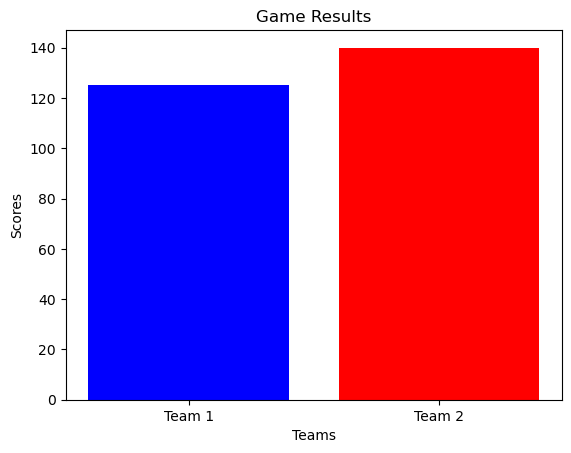

Dirk Midrange and missed.
Russell grabs the defensive rebound.
Reaves Midrange and made Ast. Davis
0-2
Derrick Jones Inside and made Ast. Dirk
2-2
Russell Inside and made.
2-4
Dirk 3pt and made Ast. Luka
5-4
James Midrange and made Ast. Reaves
5-6
Luka Midrange and made Ast. Kyrie
7-6
Davis Midrange and made Ast. James
7-8
Lively 3pt and made Ast. Luka
10-8
James Midrange and missed.
Dirk grabs the defensive rebound.
Kyrie 3pt and made Ast. Derrick Jones
13-8
Davis Inside and made Ast. James
13-10
Derrick Jones 3pt and made Ast. Kyrie
16-10
Reaves 3pt and made Ast. Davis
16-13
Dirk 3pt and made Ast. Luka
19-13
Hachimura 3pt and made Ast. James
19-16
Kyrie Inside and made.
21-16
Russell Midrange and made Ast. Davis
21-18
Dirk 3pt and made Ast. Kyrie
24-18
Davis 3pt and made.
24-21
Luka 3pt and made Ast. Kyrie
27-21
Hachimura 3pt and made Ast. Russell
27-24
Kyrie 3pt and missed.
Reaves grabs the defensive rebound.
Reaves Midrange and missed.
Kyrie grabs the defensive rebound.
Lively Midr

In [11]:
import matplotlib.pyplot as plt

def plot_game_results(team1_score, team2_score):
    labels = ['Team 1', 'Team 2']
    scores = [team1_score, team2_score]
    plt.bar(labels, scores, color=['blue', 'red'])
    plt.xlabel('Teams')
    plt.ylabel('Scores')
    plt.title('Game Results')
    plt.show()

def display_box_score(team):
    print(f"Box Score for {team.name}:")
    for player in team.players:
        print(f"{player.name} - Points: {player.points}, Assists: {player.assists}, "
              f"Shots Made: {player.shots_made}, Shots Attempted: {player.shots_attempted}, "
              f"DRebs: {player.defRebounds}, ORebs: {player.offRebounds}")

# Example usage
team1_players = [
    Player('Kyrie', 'PG', 75, 75, 85, 55, 85, 80, 80, 25, 30),
    Player('Luka', 'SG', 85, 75, 80, 60, 80, 40,90, 35, 65),
    Player('Derrick Jones', 'SF', 50, 45, 88, 78, 82,76,45, 10,50),
    Player('Lively', 'PF', 74, 10, 15, 75, 79, 50,30, 13, 70),
    Player('Dirk', 'C', 82, 70, 86, 80, 81, 45,65, 25, 60)
]

team2_players = [
    Player('Russell', 'PG', 80, 75, 50, 55, 85, 80, 65, 25, 30),
    Player('Reaves', 'SG', 76, 73, 57, 45, 80, 70,50, 15, 25),
    Player('James', 'SF', 75, 78, 85, 78, 82,76,90, 30,60),
    Player('Hachimura', 'PF', 70, 70, 75, 75, 79, 50,30, 13, 55),
    Player('Davis', 'C', 55, 83, 90, 90, 81, 45,55, 25, 80)
]

team1 = Team('Team 1', team1_players)
team2 = Team('Team 2', team2_players)

team1_score, team2_score, play_by_play = simulate_game(team1, team2, 200)
plot_game_results(team1_score, team2_score)

# Display play-by-play
for play in play_by_play:
    print(play)

# Display box scores
display_box_score(team1)
display_box_score(team2)


In [99]:
#pip install notebook
